# Further Exploration of Machine Learning Models
As explained in baselineModelTesting.ipynb, we want to predict lap distance given other lap data. We chose to use a Linear Regression algorithm for the baseline model, and got RMSE and MAE values of 1.88 and 0.8 respectively. Now, we will train models on the other candidate algorithms (both with and without cross validation) and compare to this baseline model. These algorithms include KNN, Decision Trees, Random Forests, and Gradient Boosting. 

## Import Modules and Clean the Data

In [26]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

#global variables for randomness seed and test size
global_random_state = 69420
global_test_size = 0.2

# Drop useless columns
packetTrainingDataPath="../training_data/Elysia.Laps.feather"
df = pd.read_feather(packetTrainingDataPath)
df = df.drop(
        columns=[
            "msgType",
            "_id.$oid",
            "averagepackCurrent.$numberDouble",
            "timestamp.$numberLong",
            "secondsdifference",
        ]
    )

#we need the averagepackCurrent data to be numeric instead of {"$numberDouble": "NaN"}, setting errors='coerce' sets them to numerical NaN
df['averagepackCurrent'] = pd.to_numeric(df['averagepackCurrent'], errors='coerce')

#drop the 4 rows with null values
df = df.dropna(subset=['distance', 'averagepackCurrent', 'averagespeed'])

# Remove outliers from the data
#to do this, first define a threshold for outliers (3 standard deviations which contains 99.7% of data)
threshold = 3 * np.std(df['distance'])

#remove the outliers
df = df[(df['distance'] >= -threshold) & (df['distance'] <= threshold)]
#remove negative distance values
df = df[df['distance'] >= 0]

#seperate distance from the other features
X = df[['totalpowerin', 'totalpowerout', 'netpowerout', 'amphours', 
    'averagepackCurrent', 'batterysecondsremaining', 'averagespeed']]
y = df['distance']

display(df) #should be 199x8

,totalpowerin,totalpowerout,netpowerout,distance,amphours,batterysecondsremaining,averagespeed,averagepackCurrent
3,793.532455,1803.385827,1009.853372,2.814824,97.800003,22425,49.584229,15.70
4,798.704841,685.739611,-112.965230,4.118535,95.300003,56521,24.939703,6.07
5,585.339547,2634.298876,2048.959329,3.974127,93.599998,14468,54.412831,23.29
6,681.537550,2573.828806,1892.291255,3.987067,91.900002,14517,55.419749,22.79
7,559.875099,2739.047764,2179.172665,3.994517,90.099998,13283,55.529298,24.42
...,...,...,...,...,...,...,...,...
202,537.555507,1679.129062,1141.573555,3.952078,3.800000,740,44.881966,18.49
203,475.938651,1666.858482,1190.919832,3.963359,2.100000,406,43.894226,18.62
204,700.176665,566.324558,-133.852107,0.181906,4.700000,100215,1.106129,-5.78
205,615.194700,1680.524756,1065.330056,3.963687,3.000000,611,41.645220,17.67


## KNN

This is the n_neighbors number the model should be training on: 20


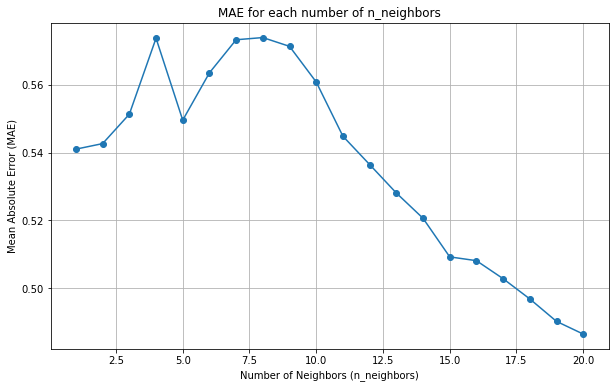

MAE for n_neighbors=1: 0.5410108892598948
MAE for n_neighbors=2: 0.5426444457645021
MAE for n_neighbors=3: 0.5513075877791929
MAE for n_neighbors=4: 0.573686912528912
MAE for n_neighbors=5: 0.5495526073067393
MAE for n_neighbors=6: 0.5634956319442919
MAE for n_neighbors=7: 0.5732355218202718
MAE for n_neighbors=8: 0.5738835808214869
MAE for n_neighbors=9: 0.571293157667966
MAE for n_neighbors=10: 0.5607889033389646
MAE for n_neighbors=11: 0.5448196712094987
MAE for n_neighbors=12: 0.5364807313533111
MAE for n_neighbors=13: 0.5280962038800316
MAE for n_neighbors=14: 0.5206492283871483
MAE for n_neighbors=15: 0.50927465617411
MAE for n_neighbors=16: 0.5081548192759396
MAE for n_neighbors=17: 0.5028496564392458
MAE for n_neighbors=18: 0.4968811868517823
MAE for n_neighbors=19: 0.4902695300407429
MAE for n_neighbors=20: 0.4865336079257342
RMSE for KNN is: 1.7631053829435306
MAE for KNN is: 0.9387104717208447


In [15]:
#HYPERPARAMTER TUNING FOR KNN
from sklearn.model_selection import GridSearchCV

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=global_test_size, random_state=global_random_state)

#train the model with KNN
#knn_model = KNeighborsRegressor(n_neighbors=5)
# Define the parameter grid
param_grid = {'n_neighbors': range(1, 21)}

# Use GridSearchCV to find the best number of neighbors
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train, y_train)

# Set the best number of neighbors
knn_model = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'])
print(f"This is the n_neighbors number the model should be training on: {grid_search.best_params_['n_neighbors']}")
knn_model.fit(X_train, y_train)
import matplotlib.pyplot as plt

# Plot the MAE for each number of n_neighbors
plt.figure(figsize=(10, 6))
plt.plot(param_grid['n_neighbors'], -grid_search.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE for each number of n_neighbors')
plt.grid(True)
plt.show()

mae_scores = -grid_search.cv_results_['mean_test_score']
for n, mae in zip(param_grid['n_neighbors'], mae_scores):
    print(f"MAE for n_neighbors={n}: {mae}")

#get predictions on the test data
y_pred_knn = knn_model.predict(X_test)

#evaluate using RMSE and MAE
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"RMSE for KNN is: {rmse_knn}")
print(f"MAE for KNN is: {mae_knn}")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=global_test_size, random_state=global_random_state)

newKNN_model = KNeighborsRegressor(n_neighbors=5)
newKNN_model.fit(X_train, y_train)

y_pred_dt = newKNN_model.predict(X_test)

rmse_newknn = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_newknn = mean_absolute_error(y_test, y_pred_dt)

print(f"RMSE for Decision Trees is: {rmse_newknn}")
print(f"MAE for Decision Trees is: {mae_newknn}")

RMSE for Decision Trees is: 1.7601743147139357
MAE for Decision Trees is: 0.93758609865129


## KNN with Cross Validation

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=global_random_state)
knn_model = KNeighborsRegressor(n_neighbors=5)

rmse_scores_knn = []
mae_scores_knn = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_val)
    
    rmse_scores_knn.append(np.sqrt(mean_squared_error(y_val, y_pred_knn)))
    mae_scores_knn.append(mean_absolute_error(y_val, y_pred_knn))

print(f"Average RMSE of KNN with Cross Validation is: {np.mean(rmse_scores_knn)}")
print(f"Average MAE of KNN with Cross Validation is: {np.mean(mae_scores_knn)}")

Average RMSE of KNN with Cross Validation is: 1.3027346860967934
Average MAE of KNN with Cross Validation is: 0.6564721744528997


## Decision Trees

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=global_test_size, random_state=global_random_state)

dt_model = DecisionTreeRegressor(random_state=global_random_state)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print(f"RMSE for Decision Trees is: {rmse_dt}")
print(f"MAE for Decision Trees is: {mae_dt}")

RMSE for Decision Trees is: 1.9269982143851523
MAE for Decision Trees is: 1.0067465393990278


## Decision Trees with Cross Validation

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=global_random_state)
dt_model = DecisionTreeRegressor(random_state=global_random_state)

rmse_scores_dt = []
mae_scores_dt = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_val)
    
    rmse_scores_dt.append(np.sqrt(mean_squared_error(y_val, y_pred_dt)))
    mae_scores_dt.append(mean_absolute_error(y_val, y_pred_dt))

print(f"Average RMSE of Decision Trees with Cross Validation is: {np.mean(rmse_scores_dt)}")
print(f"Average MAE of Decision Trees with Cross Validation is: {np.mean(mae_scores_dt)}")

Average RMSE of Decision Trees with Cross Validation is: 1.6194096052355795
Average MAE of Decision Trees with Cross Validation is: 0.7345414044039864


## Random Forests

In [20]:
# HYPERPARAMETER TUNING FOR RANDOM FORESTS

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=global_test_size, random_state=global_random_state)
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters for Random Forest
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=global_random_state), param_grid_rf, scoring='neg_mean_absolute_error', cv=5)
grid_search_rf.fit(X_train, y_train)

# Set the best hyperparameters
rf_model = RandomForestRegressor(**grid_search_rf.best_params_, random_state=global_random_state)
print(f"Best hyperparameters for Random Forest: {grid_search_rf.best_params_}")
rf_model.fit(X_train, y_train)

# Get predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate using RMSE and MAE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"RMSE for Random Forests is: {rmse_rf}")
print(f"MAE for Random Forests is: {mae_rf}")

Best hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
RMSE for Random Forests is: 1.6678055537819902
MAE for Random Forests is: 0.9348572302396694


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=global_test_size, random_state=global_random_state)

rf_model = RandomForestRegressor(random_state=global_random_state)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"RMSE for Random Forests is: {rmse_rf}")
print(f"MAE for Random Forests is: {mae_rf}")

RMSE for Random Forests is: 1.7014263662227194
MAE for Random Forests is: 0.9749912091165533


## Random Forests with Cross Validation

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=global_random_state)
rf_model = RandomForestRegressor(random_state=global_random_state)

rmse_scores_rf = []
mae_scores_rf = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_val)
    
    rmse_scores_rf.append(np.sqrt(mean_squared_error(y_val, y_pred_rf)))
    mae_scores_rf.append(mean_absolute_error(y_val, y_pred_rf))

print(f"Average RMSE of Random Forests with Cross Validation is: {np.mean(rmse_scores_rf)}")
print(f"Average MAE of Random Forests with Cross Validation is: {np.mean(mae_scores_rf)}")

Average RMSE of Random Forests with Cross Validation is: 1.1449132726496747
Average MAE of Random Forests with Cross Validation is: 0.6261941042077885


## Gradient Boosting

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=global_test_size, random_state=global_random_state)

gb_model = GradientBoostingRegressor(random_state=global_random_state)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"RMSE for Gradient Boosting is: {rmse_gb}")
print(f"MAE for Gradient Boosting is: {mae_gb}")

RMSE for Gradient Boosting is: 1.6968263362694784
MAE for Gradient Boosting is: 0.9372560536881501


## Gradient Boosting with Cross Validation

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=global_random_state)
gb_model = GradientBoostingRegressor(random_state=global_random_state)

rmse_scores_gb = []
mae_scores_gb = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_val)
    
    rmse_scores_gb.append(np.sqrt(mean_squared_error(y_val, y_pred_gb)))
    mae_scores_gb.append(mean_absolute_error(y_val, y_pred_gb))

print(f"Average RMSE of Gradient Boosting with Cross Validation is: {np.mean(rmse_scores_gb)}")
print(f"Average MAE of Gradient Boosting with Cross Validation is: {np.mean(mae_scores_gb)}")

min_distance = df['distance'].min()
max_distance = df['distance'].max()
average_distance = df['distance'].mean()
percentile_25 = np.percentile(df['distance'], 25)
percentile_50 = np.percentile(df['distance'], 50)
percentile_75 = np.percentile(df['distance'], 75)

print("Minimum distance:", min_distance)
print("Maximum distance:", max_distance)
print("Average distance:", average_distance)
print(f"25th percentile of distance: {percentile_25}")
print(f"50th percentile (median) of distance: {percentile_50}")
print(f"75th percentile of distance: {percentile_75}")

Average RMSE of Gradient Boosting with Cross Validation is: 1.2157971010564363
Average MAE of Gradient Boosting with Cross Validation is: 0.6490862023426779
Minimum distance: 0.0162265625
Maximum distance: 8.745853515625
Average distance: 4.063722782813743
25th percentile of distance: 3.963570068359375
50th percentile (median) of distance: 3.9834296875
75th percentile of distance: 4.0039501953125


## Ranking and Evaluation on Performance

### Ranking Criteria
As mentioned in the conclusion of baselineModelTesting, we want low MAE and RMSE scores, with a priority on lower MAE over RMSE. 

### Model Performance
1. **Random Forests with Cross Validation**
    - **MAE:** 0.6262
    - **RMSE:** 1.1449

2. **Gradient Boosting with Cross Validation**
    - **MAE:** 0.6491
    - **RMSE:** 1.2158

3. **KNN with Cross Validation**
    - **MAE:** 0.6565
    - **RMSE:** 1.3027

4. **Decision Trees with Cross Validation**
    - **MAE:** 0.7345
    - **RMSE:** 1.6194

5. **Random Forests**
    - **MAE:** 0.9349
    - **RMSE:** 1.6678

6. **Gradient Boosting**
    - **MAE:** 0.9373
    - **RMSE:** 1.6968

7. **KNN**
    - **MAE:** 0.9376
    - **RMSE:** 1.7601

8. **Decision Trees**
    - **MAE:** 1.0067
    - **RMSE:** 1.9270

### Summary
Based on the MAE scores, the models are ranked as follows:
1. Random Forests with Cross Validation
2. Gradient Boosting with Cross Validation
3. KNN with Cross Validation
4. Decision Trees with Cross Validation
5. Random Forests
6. Gradient Boosting
7. KNN
8. Decision Trees

All these models perform worse than the baseline model, which had MAE and RMSE of 0.57 and 1.07 respectively. Of the new models, the best performing was Random Forests with Cross Validation which has MAE and RMSE scores of 0.6262 and 1.1449. Because the majority of our data is between 3.9-4.0 and MAE is 0.6262, it means predictions are normally 15.66% to 16% off from the real distance value. This is a slight deterioration from the baseline model, which had predictions which were 14.35% different. 

To be sure the baseline model is truly the best, we will try to improve the top few models through hyperparameter tuning. 

# Hyperparameter Tuning
Lets try to improve the top contending model by tuning hyperparameters with a Grid Search. 

## Tuning of Random Forests with Cross Validation

In [ ]:
#making custom scorers
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

#hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


rf_model = RandomForestRegressor(random_state=global_random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=global_random_state)

#perform GridSearchCV with RMSE and MAE scoring
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring={'RMSE': rmse_scorer, 'MAE': mae_scorer},
    refit='RMSE',
    cv=kf,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

#store the best model and its parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best RMSE Score: {-grid_search.best_score_:.4f}")
print(f"Best MAE Score: {-grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_]:.4f}")

rmse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_val)
    
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    mae_scores.append(mean_absolute_error(y_val, y_pred))

print(f"Final Average RMSE for Random Forests w/ Cross Validation (on the best model): {np.mean(rmse_scores):.4f}")
print(f"Final Average MAE for Random Forests w/ Cross Validation (on the best model): {np.mean(mae_scores):.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max

# Conclusion
It is clear to see that hyperparameter tuning did not significantly improve the Random Forest model. Although the RMSE improved from 1.1449 to 1.1251, and MAE from 0.6262 to 0.6175, the baseline Linear Regresison model performs better according to both metrics. 

### Why the Linear Regression may be outperforming
Although one may have expected a more refined and complex algorithm such as Random Forests to perform the best, the baseline regression model may be outperforming more complex algorithms due to the size of our data. with 208 packets (rows) of data, it means only about 160 are being trained on, and 40 to test with after the train_test_split. As explained at the beginning of baselineModelTesting.ipynb, more complex algorithms are prone to overfit on small datasets, which is why we chose a simple Linear Regression as the baseline model. 

In addition, Linear Regressions generally tend to perform particularly well when relationships within data are easily interpretable or show a linear relation. For example, it should be obvious that the more battery in the car, the more distance it can travel. Or the faster the car travels, the less distance it will be able to travel. Since the lap data is full of simple relationships like these, it will overfit less often than a Random Forest might. 

### What even is RMSE/MAE? How does it relate to accuracy and precision?
MAE (Mean Absolute Error) is the average of the absolute differences between predicted and actual distance values. That is, it measures the average magnitude of errors in a set of predictions, without considering their direction. MAE differs from RMSE in how it is less sensitive to outliers compared to RMSE because it does not square the errors.

RMSE (Root Mean Squared Error) is the square root of the average of the squared differences between predicted and actual values. It measures the average magnitude of errors, giving more weight to larger errors due to the squaring it does. That is, RMSE is more sensitive to outliers because it squares the errors, which can disproportionately affect the metric if there are large errors.

Here are some examples to put the two simply.\
**MAE**: Imagine you are trying to guess (make a prediction on) the distance a car will travel in a lap. If you guess wrong, MAE tells you, on average, how far off your guesses are from the actual distances. It’s like saying, "On average, my guesses are off by about 0.57 units."

**RMSE**: Now, if you make a few really bad guesses, RMSE will highlight these more because it squares the errors. It’s like saying, "If I make a big mistake, it will really show up in my RMSE score." RMSE gives you a sense of how bad your worst mistakes are.

When it comes to accuracy and precision, accuracy refers to how close the model's predictions are to the actual values. RMSE can be seen as a measure of accuracy because it penalizes larger errors more, thus providing a sense of how far off the predictions can be. Precision refers to the consistency of the model's predictions. A model with high precision will have predictions that are close to each other.
MAE can be seen as a measure of precision because it shows the average error without emphasizing larger errors.

### What does this mean for Helios?
When it comes to Helios, predicting lap distances accurately is useful in optimizing performance and driving strategy. Here are a few scenarios where MAE and RMSE come into play: 

**Energy Management**:\
MAE: With a low MAE, it means our model is generally good at predicting lap distances. We can use this to plan energy consumption more precisely, ensuring that the car has enough power to complete the race without running out of battery.

RMSE: If the RMSE is high, it indicates that there are some laps where the prediction is significantly off. This could mean unexpected energy usage, whether because there is something wrong with the car or due to irregular driving style. So, we may need to have contingency plans for such laps.

**Performance Monitoring**:\
MAE: Regularly monitoring MAE will help ensure the model remains reliable over time. If MAE starts increasing, it might indicate that the model needs retraining or that there are changes in the car’s performance.

RMSE: Keeping an eye on RMSE will help us catch significant issues early. If RMSE spikes, there was likely outlier data introduced, which could mean there’s a problem with the car or the data, prompting further investigation into driving behaviour. 

### Real world example
Suppose the model predicts that the car will travel 4.0 units in the next lap, but the actual distance varies. With a MAE of 0.57, we can expect that, on average, the prediction will be within 0.57 units of the actual distance. This helps to plan energy usage more accurately.

However, since RMSE is 1.07, it means that while most predictions are close, some could be off by more than 1 unit. This indicates that there should be a buffer in the energy planning to account for these large errors, ensuring that the car doesn’t run out of power unexpectedly.

By understanding and applying MAE and RMSE, we can make informed decisions to optimize the car’s performance, manage energy efficiently, and improve overall race strategy.



